This time, let's use a Generative Adversarial Network to generate wildflower images.
For this one, we may want to have a larger dataset to work from, so this may take some time to train

In [65]:
import os
import sys
import numpy as np
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib as mpl
import pathlib
import random
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import wfutils

ROOT_DIR = "."
NOTEBOOK_ID = "GANS"
IMAGE_PATH = os.path.join(ROOT_DIR, "images", NOTEBOOK_ID)


# Setup


In [66]:
# Set the random seed
random_seed = 42
tf.random.set_seed(random_seed)

In [67]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import images

We might as well use our image dataset I got from my father (Why am I writing as if I were teaching?)

In [68]:
data_path = Path("../data/tiny")

# Setup train and testing paths
train_dir = Path(data_path, "train")
test_dir = Path(data_path, "test")
val_dir = Path(data_path, "val")

train_dir, test_dir, val_dir

(PosixPath('../data/tiny/train'),
 PosixPath('../data/tiny/test'),
 PosixPath('../data/tiny/val'))

In [5]:


# Normalize all pixel values using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
IMAGE_HEIGHT = 50  #224x224 will crash the kernel
IMAGE_WIDTH = 50
IMAGE_DEPTH = 3  # rgb

batch_size = 16
epochs = 10

In [207]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=batch_size,           # number of images to process at a time 
                                               target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # convert all images to be 224 x 224
                                               class_mode="input",     # type of problem we're working on  - 'input' is used for autoencoders like this one
                                               seed=42,
                                               )

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=batch_size,           # number of images to process at a time 
                                               target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # convert all images to be 224 x 224
                                               class_mode="input",     # type of problem we're working on  - 'input' is used for autoencoders like this one
                                               seed=42)

Found 62 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


In [9]:
train_data.samples

5308

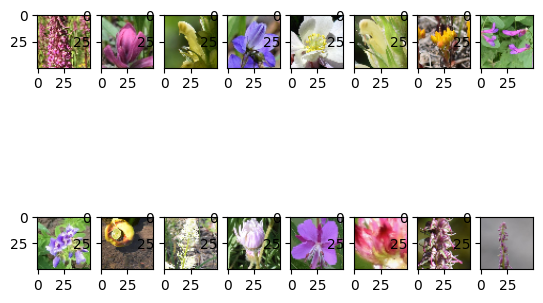

In [11]:
import math
#view a batch
num_rows = 2
num_cols = math.ceil(batch_size/num_rows)

x, y = next(train_data)
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

# A simple GAN

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(250, activation="selu"),
    keras.layers.Dense(IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_DEPTH , activation="sigmoid"),
    keras.layers.Reshape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
])
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH]),
    keras.layers.Dense(250, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])



2024-08-01 16:47:35.724649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 16:47:35.724764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 16:47:35.724823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 16:47:35.918933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-01 16:47:35.919020: I external/local_xla/xla/stream_executor

In [13]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [14]:
x,_ = next(train_data)
x.shape

(16, 50, 50, 3)

In [15]:
y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
y1.shape

TensorShape([32, 1])

In [16]:
noise = tf.random.normal(shape=[batch_size, codings_size])
noise.shape

TensorShape([16, 30])

In [17]:
generated_images = generator(noise)
print(generated_images.shape)
X_fake_and_real = tf.concat([generated_images, x], axis=0)

(16, 50, 50, 3)


In [18]:
X_fake_and_real.shape

TensorShape([32, 50, 50, 3])

In [19]:
y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
y1.shape

TensorShape([32, 1])

This looks right, so why does it think X_fake_and_real is of size 28?

In [20]:
# discriminator.trainable = True
# discriminator.train_on_batch(X_fake_and_real, y1)

2024-08-01 16:47:43.917514: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f1499dbd420 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-01 16:47:43.917563: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2024-08-01 16:47:43.931421: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-01 16:47:43.957024: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1722552464.021406 1468952 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


0.9036617875099182

WTF, it works here... mabe the last batch is smaller... 
is it that we need to make sure we drop remainders in our batches?

In [21]:

#dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(1000)
#dataset = train_data.batch(batch_size, drop_remainder=True).prefetch(1)

# Utils

In [69]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        image = np.clip(image, 0,1)
        #image = image/255
        plt.imshow(image)
        plt.axis("off")

In [122]:
from tqdm import tqdm
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    #for epoch in tqdm(range(n_epochs)):
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs), end='\r') # not shown in the book
        batch_num = 0
        for X_batch in dataset:
            #print("Num batches seen: ", dataset.total_batches_seen, end = "\r")
            batch_num += 1
            #print("Batch number: ", batch_num, end='\r')
            # to accomodate for the final batch that might have fewer good images reset batch size to actual value
            if X_batch[0].shape[0] != batch_size:
                #print(f"Batch size was {X_batch[0].shape[0]}")
                break
            X_batch =tf.cast(X_batch[0], tf.float32)  #CJA added so that concat will work
            # phase 1 - training the discriminator
            
            noise = tf.random.normal(shape=[batch_size, codings_size])
            #noise
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        if epoch % 50 == 1: 
            plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

In [ ]:
train_gan(gan, train_data, batch_size, codings_size, n_epochs=100)

# DEEP Convolutional GAN

In [107]:
# Normalize all pixel values using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [162]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_DEPTH = 3  # rgb
batch_size = 16

codings_size = 500

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=batch_size,           # number of images to process at a time 
                                               target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # convert all images to be 224 x 224
                                               class_mode="input",     # type of problem we're working on  - 'input' is used for autoencoders like this one
                                               seed=42,
                                               color_mode ='rgb'
                                               )

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=batch_size,           # number of images to process at a time 
                                               target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # convert all images to be 224 x 224
                                               class_mode="input",     # type of problem we're working on  - 'input' is used for autoencoders like this one
                                               seed=42)

Found 62 images belonging to 1 classes.
Found 20 images belonging to 1 classes.


### Old generator, as the convolutional generator produces lots of artifacts and doesn't seem to converge at all

In [163]:
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(200, activation="selu"),
    keras.layers.Dense(500, activation="selu"),
    keras.layers.Dense(IMAGE_HEIGHT * IMAGE_WIDTH * IMAGE_DEPTH , activation="sigmoid"),
    keras.layers.Reshape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH])
])

In [164]:
generator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               50100     
                                                                 
 dense_17 (Dense)            (None, 200)               20200     
                                                                 
 dense_18 (Dense)            (None, 500)               100500    
                                                                 
 dense_19 (Dense)            (None, 12288)             6156288   
                                                                 
 reshape_10 (Reshape)        (None, 64, 64, 3)         0         
                                                                 
Total params: 6327088 (24.14 MB)
Trainable params: 6327088 (24.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [195]:
#tf.random.set_seed(42)
#np.random.seed(42)


startsize = int(IMAGE_HEIGHT/8)


dc_generator = keras.models.Sequential([
    keras.layers.Dense(startsize * startsize * (4*IMAGE_HEIGHT), input_shape=[codings_size], name="Dense_gen_input"),
    keras.layers.Reshape([startsize, startsize, (4*IMAGE_HEIGHT)]), # start with 8x8x256 32x32x1024 noise
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(2*IMAGE_HEIGHT, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"), # upsample to 16x16x128 64x64x512 ( we could add more layers of upsampling)
    # keras.layers.Conv2D(2*IMAGE_HEIGHT, kernel_size=5, padding="SAME", activation="selu"),
    # keras.layers.Conv2D(2*IMAGE_HEIGHT, kernel_size=5, padding="SAME", activation="selu"),
    # keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(IMAGE_HEIGHT, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"), # upsample to 32x32x64 128x128x256 ( we could add more layers of upsampling)
    # keras.layers.Conv2DTranspose(IMAGE_HEIGHT, kernel_size=5, padding="SAME", activation="selu"),
    # keras.layers.Conv2DTranspose(IMAGE_HEIGHT, kernel_size=5, padding="SAME", activation="selu"),
    # keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(IMAGE_HEIGHT/2, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"), # upsample to 64x64x64 256x256x128( we could add more layers of upsampling)
    # keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding="SAME", # 64x64x3 image, NOTE: strides=4, to get to 64 if we don't use the layer above
                                 activation="tanh"),
    #keras.layers.BatchNormalization(),
], name="generator")

In [196]:
dc_generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_gen_input (Dense)     (None, 16384)             8208384   
                                                                 
 reshape_13 (Reshape)        (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_36 (Ba  (None, 8, 8, 256)         1024      
 tchNormalization)                                               
                                                                 
 conv2d_transpose_34 (Conv2  (None, 16, 16, 128)       819328    
 DTranspose)                                                     
                                                                 
 conv2d_transpose_35 (Conv2  (None, 32, 32, 64)        204864    
 DTranspose)                                                     
                                                         

In [197]:



dc_discriminator = keras.models.Sequential([
    keras.layers.Conv2D(IMAGE_HEIGHT, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH]),
                        #input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(IMAGE_HEIGHT*2, kernel_size=5, strides=2, padding="SAME",  # downsample to 128
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(IMAGE_HEIGHT*4, kernel_size=5, strides=2, padding="SAME",  # downsample to 256
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(IMAGE_HEIGHT*8, kernel_size=5, strides=2, padding="SAME",  # downsample to 512
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid", name="Dense_disc_out")  # real or fake
], name = 'discriminator')


In [198]:
dc_discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 dropout_36 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_39 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 dropout_37 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 conv2d_40 (Conv2D)          (None, 8, 8, 256)         819456    
                                                                 
 dropout_38 (Dropout)        (None, 8, 8, 256)         0         
                                                                 
 conv2d_41 (Conv2D)          (None, 4, 4, 512)       

In [199]:
#dc_gan = keras.models.Sequential([dc_generator, dc_discriminator])
# old generator since new one gives bad results
dc_gan = keras.models.Sequential([generator, dc_discriminator])

In [200]:
optimizer = keras.optimizers.Nadam(learning_rate=0.0001)

In [201]:
#dc_gan = keras.models.load_model("../models/Wf_GAN_Conv")

In [202]:
dc_gan.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 64, 64, 3)         6327088   
                                                                 
 discriminator (Sequential)  (None, 1)                 4314753   
                                                                 
Total params: 10641841 (40.60 MB)
Trainable params: 10641841 (40.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [203]:
dc_discriminator.compile(loss="binary_crossentropy", optimizer="nadam")# was rmsprop
dc_discriminator.trainable = False
dc_gan.compile(loss="binary_crossentropy", optimizer="nadam")# was rmsprop

In [204]:
# X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale
#X_train_dcgan = train_data.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [205]:
batch_size = 16
# dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
# dataset = dataset.shuffle(1000)
# dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

# RUN

2024-08-02 14:28:18.439841: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indiscriminator/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


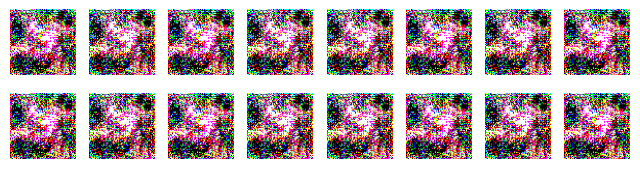

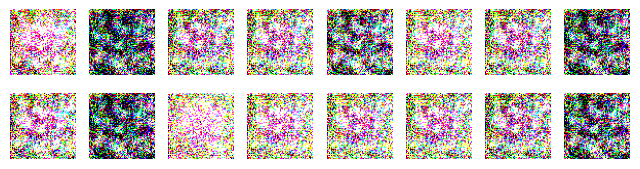

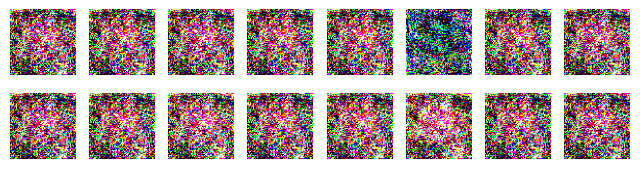

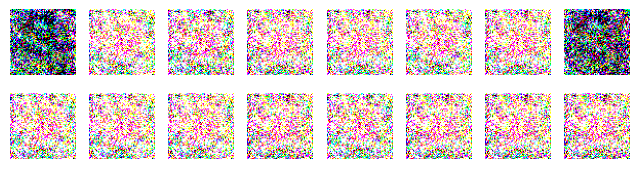

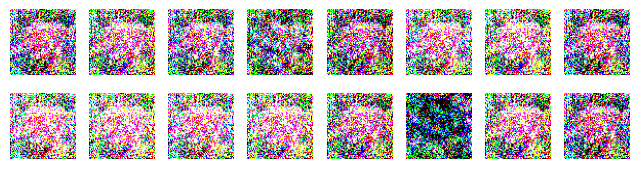

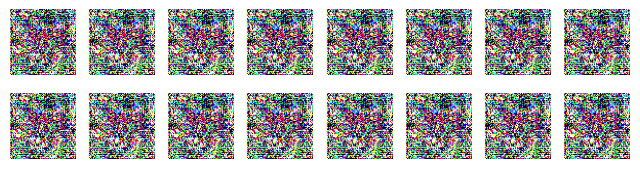

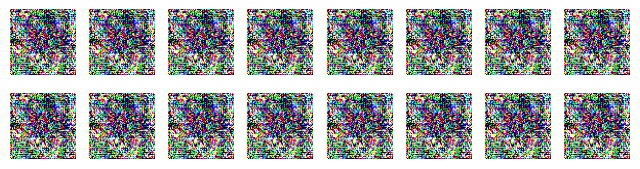

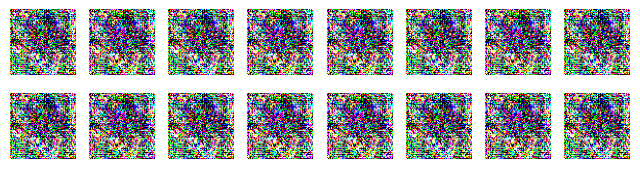

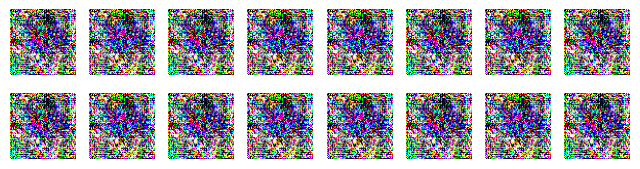

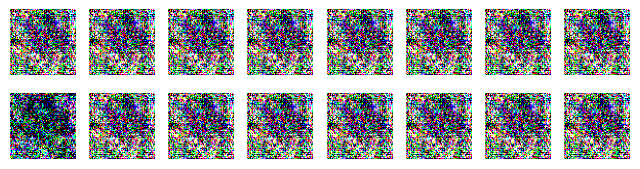

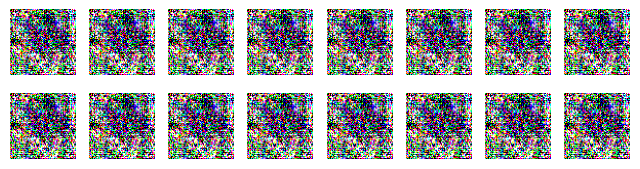

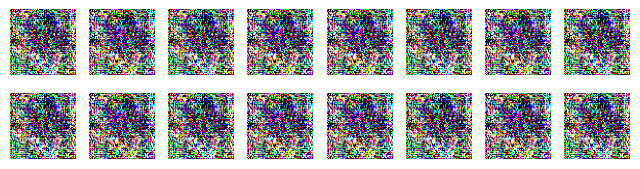

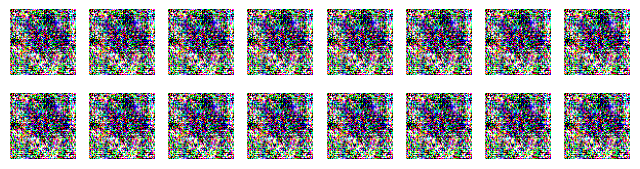

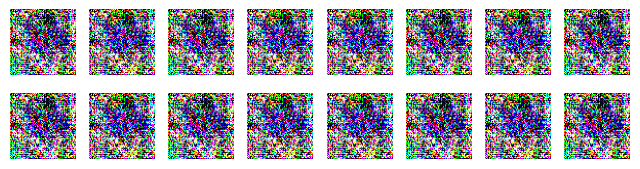

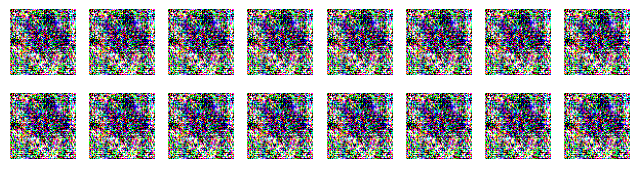

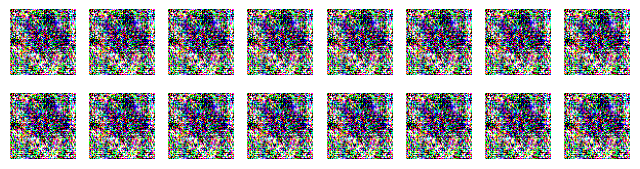

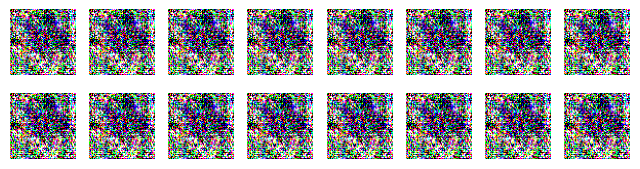

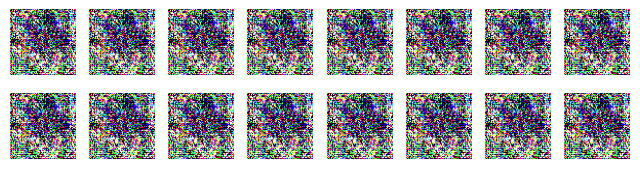

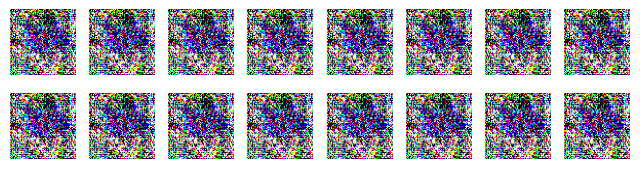

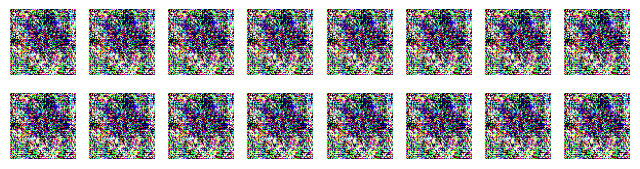

In [206]:
import wfutils
train_gan(dc_gan, train_data, batch_size, codings_size, n_epochs=1000)

In [84]:
dc_gan.save("../models/Wf_GAN_Conv")

INFO:tensorflow:Assets written to: ../models/Wf_GAN_Conv/assets


INFO:tensorflow:Assets written to: ../models/Wf_GAN_Conv/assets


This is duplicating a couple of the pictures in the test set, so looks to be overfitting just a tad.... :)

In [208]:
noise = tf.random.normal(shape=[10, codings_size])
            #noise
generated_images = generator(noise)

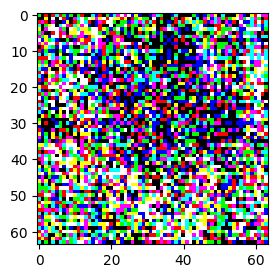

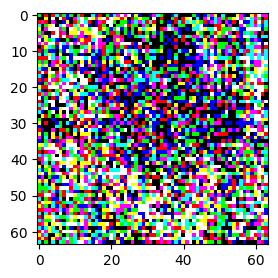

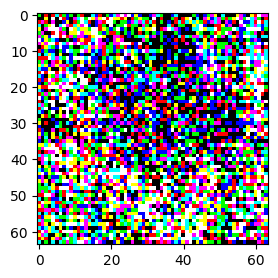

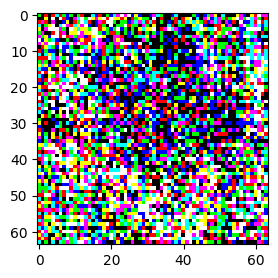

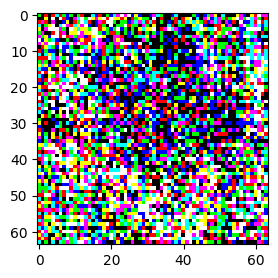

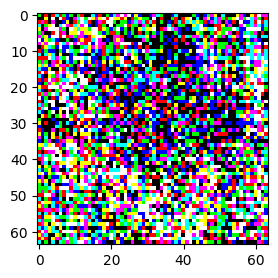

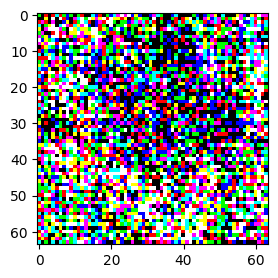

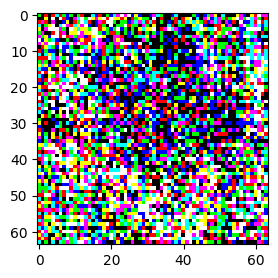

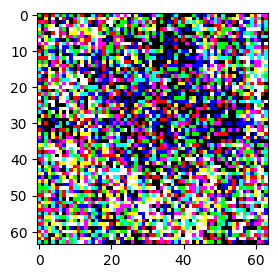

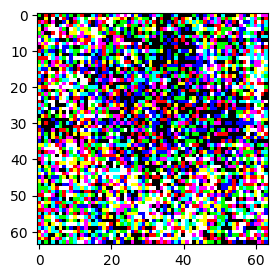

: 

In [209]:
import matplotlib.pyplot as plt
for index, image in enumerate(generated_images):
    plt.figure(figsize=(3, 3))
    plt.imshow(image)